# Large Scale Taxi Distribution With Simulated Annealing

# Problem Description
The problem we focused on is to deliver a set of packages in a city. We have the following parameters:

* **N** The number of packages to be delivered
* **K** The number of vehicles used to deliver the packages
* **M** The number of nodes in our graph of the city

Each package has a source node, and destination node. Each truck can only move one package at a time, so you can think of them like taxis moving people rather than a delivery truck delivering 100s of packages at one time. Each of the trucks starts and ends at the garage node. The city is constructed as a graph with possible locations being nodes and roads between those locations being weighted edges. The goal is to delivery all of these packages in an efficient manner.

# Solution Description
The main problem can be broken down into smaller problems.

1. Finding the best path from one location to another in the city.
2. Finding the best order to deliver a set of packages that a truck is responsible for delivering.
3. Finding the best set of packages for each truck.

To find the best path from location A to location B is a problem that can easily be solved with shortest path finding algorithms. We chose to use $A^{\star}$ for this problem as it finds the optimal path in reasonable time. Addressing problems 2 and 3 is a bit more tricky. We could through everything into one large $A^{\star}$ search, however at each step in our search we would need to generate $b^{K}$ new search nodes where $b$ is the maximum degree of node (if you imagine a basic grid most nodes would have $b=4$). This would result in a ludicrous amount of nodes being generated at each step, but it would give you the optimal if it ever managed to halt.

Instead we decided to use simulated annealing. This is where you generate an end state, then find a similar but slightly different end state. Then you test whether the new state is cheaper, if it is you move to this new state and repeat the process. If the new state is more expensive you have a chance at moving to it, but the chance of you moving to a higher cost state decreases as the program runs. Simulated annealing does not run into the state explosion that $A^{\star}$ experiences, however it is not optimal which means it will return a good result, but not necessarily the best result. Another benefit of simulated annealing is that you can get better results by allowing the program to run longer.

#Implementation

Initialize the variables for the problem:

* **N** - The number of packages to deliver
* **K** - The number of vehicles capable of delivering packages
* **M** - The number of nodes in our test graph. Depending on how you wish to interpret the results this can mean the number of intersections in a city, or number of cities, etc.
* **SEED** - The seed for the random number generator
* **THETA** - Parameter for the random graph generator. A higher theta will have less edges. Setting `theta = M` tends to make interesting graphs.
* **KMAX** - The number of steps for the annealing process. A higher number will result in a better answer but take longer.

In [1]:
# General parameters
N = 4   # Number of packages
K = 2   # Number of vehicles
M = 30  # Number of nodes in our test graph (cities, intersections, etc)

# Graph generating parameters
SEED = 52 # RNG seed
THETA = M # Graph generating parameter

# Annealing parameter
KMAX = 2000 # Steps

## Imports ##

 We start with importing some $3^\text{rd}$ party libraries.
 
* [NetworkX](https://networkx.github.io/) - Graph library
* [NumPy](http://www.numpy.org/)  - Numeric library
* [Matplotlib](http://matplotlib.org/)  - Graphing library

In [2]:
import networkx as nx 
import numpy as np
import matplotlib.pyplot as plt

Standard library imports:

In [3]:
import random
import math

Change the plotting style to something more appealing and show the graphs in-line instead of popping up a window.

In [4]:
from matplotlib import style
style.use("ggplot")
%matplotlib inline

## Construct the Test Graph ##

We need to have a graph that represents a city so here we are using the function [*geographical_threshold_graph*](http://networkx.github.io/documentation/networkx-1.9.1/reference/generated/networkx.generators.geometric.geographical_threshold_graph.html#geographical-threshold-graph) to generate a random graph:
>The geographical threshold graph model places $n$ nodes uniformly at random in a rectangular domain. Each node $u$ is assigned a weight $w_{u}$. Two nodes $u,v$ are connected with an edge if
$$w_{u}+w_{v}\ge\theta r^{α}$$
where $r$ is the Euclidean distance between $u$ and $v$, and $θ$, $α$ are parameters.

In [5]:
random.seed(SEED)

#Keep generating graphs until you find one that is connected
tries = 0
while True:
    G = nx.geographical_threshold_graph(M, THETA)
    con = nx.is_connected(G)
    if con == True:
        break
    elif tries > 100:
        print "Generated 100 graphs that were not connected. Try different parameters"
        raise RuntimeError("Poor graph generation parameter choice.")
    else:
        print "Generated a non-connected graph. Trying again..."
        tries +=1

print nx.info(G)
print "Connected: ", con

Generated a non-connected graph. Trying again...
Generated a non-connected graph. Trying again...
Generated a non-connected graph. Trying again...
Generated a non-connected graph. Trying again...
Generated a non-connected graph. Trying again...
Generated a non-connected graph. Trying again...
Generated a non-connected graph. Trying again...
Name: 
Type: Graph
Number of nodes: 30
Number of edges: 75
Average degree:   5.0000
Connected:  True


Define a function that takes a list of two nodes and computes the euclidean distance between them. This is necessary because our random graph generator will assign (x,y) positions to each node, but does not calculate the distance of the edges.

In [6]:
posD = nx.get_node_attributes(G,'pos')
def eDist(e):
    """Ecludian distance between two nodes.
    
    Input:
    e - A list of (x,y) pairs
    """
    
    x1,y1 = posD[e[0]]
    x2,y2 = posD[e[1]]
    return math.sqrt((x1-x2)**2 +(y1-y2)**2)

For each edge in the graph, assign a weight that is equal to the distance between the two nodes.

In [7]:
weightD = {}
for x in G.edges_iter():
    weightD[x] = eDist(x)
    #print x, eDist(x)
    
nx.set_edge_attributes(G, "weight", weightD)

Plot the graph:

/home/nick/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/home/nick/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


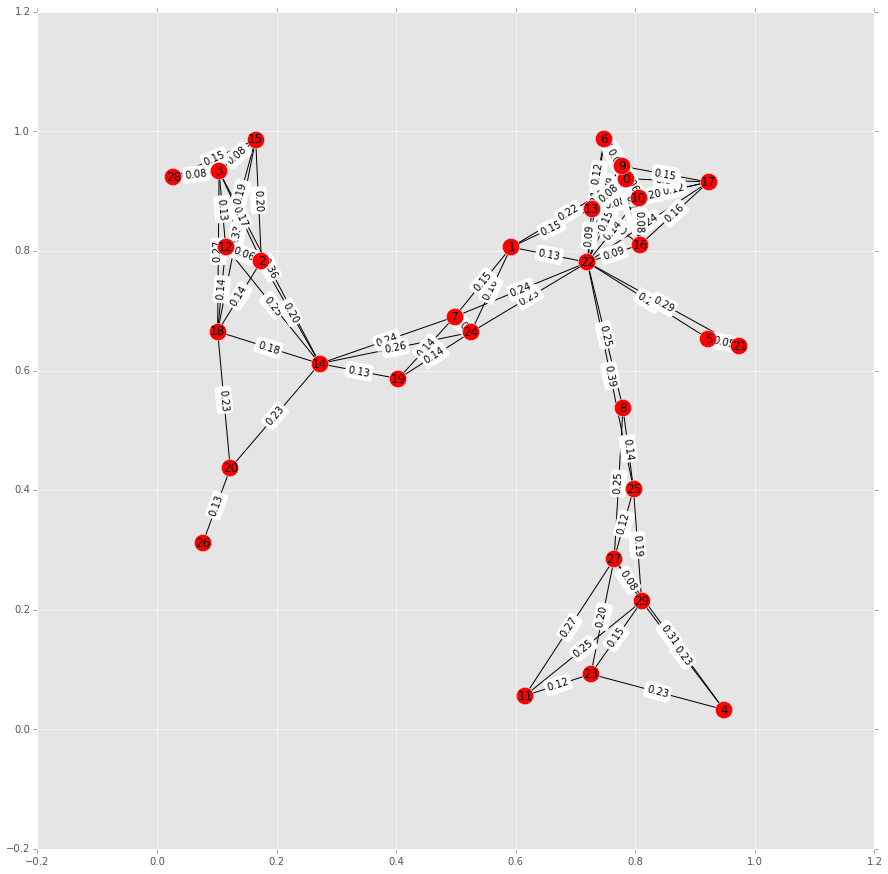

In [8]:
wLab = {}
for e,w in weightD.items():
    wLab[e] = "{:4.2f}".format(w)
    
nodeL = dict(zip(range(M), range(M)))

plt.figure(num=1, figsize=(15,15), dpi=300)
nx.draw_networkx_nodes(G,posD) # Draw nodes
nx.draw_networkx_edges(G,posD) # Draw edges
nx.draw_networkx_labels(G, posD, labels=nodeL) # Draw node numbers
nx.draw_networkx_edge_labels(G,posD,wLab)      # Draw edge weights

plt.show()

## Create Packages ##

First we create a small class used to store the package source, and destination.  
**Fields**:

* `s` - The id of the source node
* `d` - The id of the destination node

**Methods**:

* `li` - Return the source and destination as a list instead of having to access them individually

In [9]:
class Package:
    """A simple class used to store the source and dest of a package"""

    def __init__(self, source, destination):
        self.s = source
        self.d = destination
        
    def __str__(self):
        return  "(" + "{:2d}".format(self.s) + ", " + "{:2d}".format(self.d) + ")"
        
    def li(self):
        """Return the source and destination as a list"""
        return [self.s, self.d]

Now we define a function that will generate *n* packages with random sources and destinations. The only restriction is that the source can not be the destination.

In [10]:
def randomPackages(n):
    """Generate n packages with random sources and destinations"""
    
    p = []
    for i in xrange(n):
        start, end = random.sample(range(M), 2)
        p.append(Package(start,end))
    return p

Generate *N* packages and print their (source, destination) pairs.

In [11]:
packages = randomPackages(N)
for p in packages:
    print p

(22, 17)
(23,  3)
(22, 26)
(21, 29)


## Create Trucks ##

Now we define the truck class, which is a bit trickier than the package class.  

**Fields**:

* `p` - The list of packages this truck is to deliver, and the order of the list is the order in which it will deliver those packages
* `path` - The list of nodes, in the order, this truck will visit to deliver all of the packages.
* `edges` - The list of edges, in the order, this truck will use to deliver all of the packages.
* `pathCost` - The total distance this truck will need to travel
* `id` - A number used to denote this truck

**Methods**:

* `pathToEdges` - This will convert the list of nodes, `path`, into it's corresponding list of edges

In [12]:
class Truck:
    def __init__(self, id):
        self.p = []
        self.path = None
        self.edges = None
        self.pathCost = None
        self.id = id
        
    def __str__(self):
        """A printing method so that the contents of the truck can be displayed"""
        
        #Print the truck ID
        res = "T" + str(self.id)+ ": "
        
        if not(self.pathCost is None):
            res += str(self.pathCost) + "\n"
        else:
            res += "\n"
        
        # Print the path, if it exist
        if not (self.path is None):
            res += "\tPath:\n"
            for n in self.path:
                res += str(n) + " -> "
            res = res[:-4] + "\n"
        
        # Print the packages
        res += "  Packages:\n    "
        for p in self.p:
            res += " " + str(p)
        return res
    
    def pathToEdges(self):
        """Generate the set of edges from the list of nodes, path"""
        
        e = []
        for i in xrange(len(self.path)-1):
            n1 = self.path[i]
            n2 = self.path[i+1]
            if n1 != n2:
                e.append((min(n1,n2),max(n1,n2)))
        self.edges = e

We then create the *K* trucks and randomly assign the packages to the trucks.

In [13]:
trucks = [Truck(i) for i in xrange(K)]
for p in packages:
    i = random.randrange(K)
    trucks[i].p.append(p)

Print out the trucks and show the ordering of the packages.

In [14]:
def printTrucks(trucks):
    for t in trucks:
        print t
printTrucks(trucks)

T0: 
  Packages:
     (22, 17) (22, 26) (21, 29)
T1: 
  Packages:
     (23,  3)


## Set Garage Location ##

Simply pick a random node and set it as the garage location.

In [15]:
garage = random.randrange(M)
print "Garage node: ", garage

Garage node:  5


## Calculating Costs ##

Now we are getting to the fun part. Here we calculate the cost of a given state.

First we tackle how to find the path between any two nodes. This is a problem for A\* search! Here we define the heuristic as just the euclidean distance between two points since the random graph generation can create graphs for which the Manhattan distance metric would be a poor choice.

In [16]:
def h(n1,n2):
    """Euclidean distance between two nodes"""
    return eDist([n1,n2])

def findPath(n1,n2):
    """Use A* search to find the shortest path between two nodes"""
    return nx.astar_path(G,n1,n2, heuristic=h)

Now that we can find the path between two nodes we calculate how to find the path for a list of nodes visiting them in the pre-assigned order.

In [17]:
def packageListShortestPath(path):
    """Find the shortest path visiting the list of nodes in the given order"""
    
    tot = []
    for i in xrange(len(path)-1):
        tot.extend(findPath(path[i],path[i+1]))
    return tot

Then we can then find the complete path for a truck by adding the garage as the start and end of the path.

In [18]:
def truckPath(t,g):
    """Find the complete truck path including garages"""
    
    #Add garages to begining and end
    path = [g] 
    for i in t.p:
        path.extend(i.li())
    path.append(g)
    
    # Find the shortest path visiting those nodes
    t.path = packageListShortestPath(path)

We can compute the entire distance traveled by the truck. However, we will only calculate this when we don't have a stored value.

In [19]:
def truckCost(t,g):
    """Get the total distance traveled by the truck"""
    
    if t.pathCost is None:
        # Find the shortest path
        truckPath(t,g)
        
        #Convert the list of nodes to a list of edges
        t.pathToEdges()
        
        # Get the cost for each edge
        eCost=nx.get_edge_attributes(G,'weight')
        
        # Calculate the total cost
        cost = 0.0
        for e in t.edges:
            cost += eCost[e]
        t.pathCost = cost
        return cost     
    else:
        return t.pathCost


Finally given a list of trucks we can calculate the cost of the whole state. The cost is the maximum distance that any truck travels added to the average distance that all trucks travel.

In [20]:
def stateCost(trucks, g):
    """Calculate the cost of a state"""
    
    calc = []
    for truck in trucks:
        c = truckCost(truck, g)
        calc.append(c)
    return max(calc) + np.average(calc)

See what the cost of our random assignment is.

In [21]:
rEnergy = stateCost(trucks,garage)
print "Cost: ", rEnergy

Cost:  8.35279159618


## Annealing ##

 Now we have the base of the problem set up and can work on implementing the Simulated Annealing code. 

We need a function that will find a neighbor given a state. It is a bit ugly for a function so I'll explain what it does:

1. Copy the old state
2. Select a random truck that has packages, $T_{1}$
3. Select a random package from $T_{1}$, call that package $P_{1}$
4. Select another random truck denoted $T_{2}$. (Note: it is possible that $T_{1}=T_{2}$)
5. Select a random package $P_{2}$ from $T_{2}$ and insert $P_{1}$ in front of it.
6. Set the `pathCost` as needing to be recalculated
7. Return the new state

In [22]:
def copyState(s0):
    """Make a deep copy of a state (ie: list of trucks)"""
    s = []
    
    for i in xrange(len(s0)):
        t = Truck(i) #Assign the id
        
        # Copy the packages
        t.p = []
        for package in s0[i].p:
            t.p.append(package)
            
        # Copy the path
        if not(s0[i].path is None):
            t.path = [] 
            for node in s0[i].path:
                t.path.append(node)
        
        # Copy the edges
        if not(s0[i].edges is None):
            t.edges = [] 
            for edge in s0[i].edges:
                t.edges.append(edge)
        
        # Copy the path cost
        if not(s0[i].pathCost is None):
            t.pathCost = s0[i].pathCost
        
        s.append(t)
    return s

In [23]:
def permuteState(s0):
    """Move one package to a different truck/delivery position"""
    
    """Copy the old state"""
    s1 = copyState(s0)
    
    """Randomly move one package"""
    while True:                  # Loop until we find a truck with packages
        t1 = random.randrange(K) # Pick a random truck, t1
        if(len(s1[t1].p)>0):     # Make sure that truck has packages
            p1 = s1[t1].p.pop(random.randrange(len(s1[t1].p))) # Pick a random package p1, from t1 and remove it
            break
            
    t2 = random.randrange(K) # Pick a second random (with replacement) truck, t2 
    if (len(s1[t2].p)==0):   # Insert the package, p1 in a random place in truck t2
        s1[t2].p.append(p1)
    else:
        s1[t2].p.insert(random.randrange(len(s1[t2].p)),p1)
    
    # Set the pathCosts as needing to be recalculated
    s1[t1].pathCost = None
    s1[t2].pathCost = None
        
    return s1

Finally we define and run the annealing process. The standard annealing process as described by [wikipedia](http://en.wikipedia.org/wiki/Simulated_annealing#Pseudocode):  
 
    s ← s0; e ← E(s)                          // Initial state, energy.               
    k ← 0                                     // Energy evaluation count.             
    while k < kmax and e > emin               // While time left & not good enough:   
        T ← temperature(k/kmax)               // Temperature calculation.             
        snew ← neighbour(s)                   // Pick some neighbour.                 
        enew ← E(snew)                        // Compute its energy.                  
        if P(e, enew, T) > random() then      // Should we move to it?                
            s ← snew; e ← enew                // Yes, change state.                   
    k ← k + 1                                 // One more evaluation done.            
    
For our problem we are finding the lowest value, not the highest. The concept of a *good enough* answer doesn't apply to our case since we have no idea what a *good* value would be.

In [24]:
#Switch our variables to the annealing terminology
state = trucks
energy = stateCost(state,garage)
k = 0.0
bState = copyState(state)
bEnergy = energy

# Commence the annealing!
while k < KMAX:
    t = k/KMAX
    newState = permuteState(state)
    newEnergy = stateCost(newState, garage)
    
    if (newEnergy < bEnergy):
        bState = copyState(state)
        bEnergy = newEnergy
        
    if (newEnergy < energy):
        state = newState
        energy = newEnergy
    elif (t < random.random()):
        state = newState
        energy = newEnergy
    k += 1

## Results ##

In [25]:
print "Cost of our random package assignment:", rEnergy
print "Cost of the last solution:" , energy
print "Cost of our best solution: %f (%f%%  the cost of random assignment)" % (bEnergy, bEnergy/rEnergy)


Cost of our random package assignment: 8.35279159618
Cost of the last solution: 6.86106837979
Cost of our best solution: 6.861068 (0.821410%  the cost of random assignment)


### Graphs ###

Here are the plots of our best solution. The edges are labeled with the order in which they are travelled.

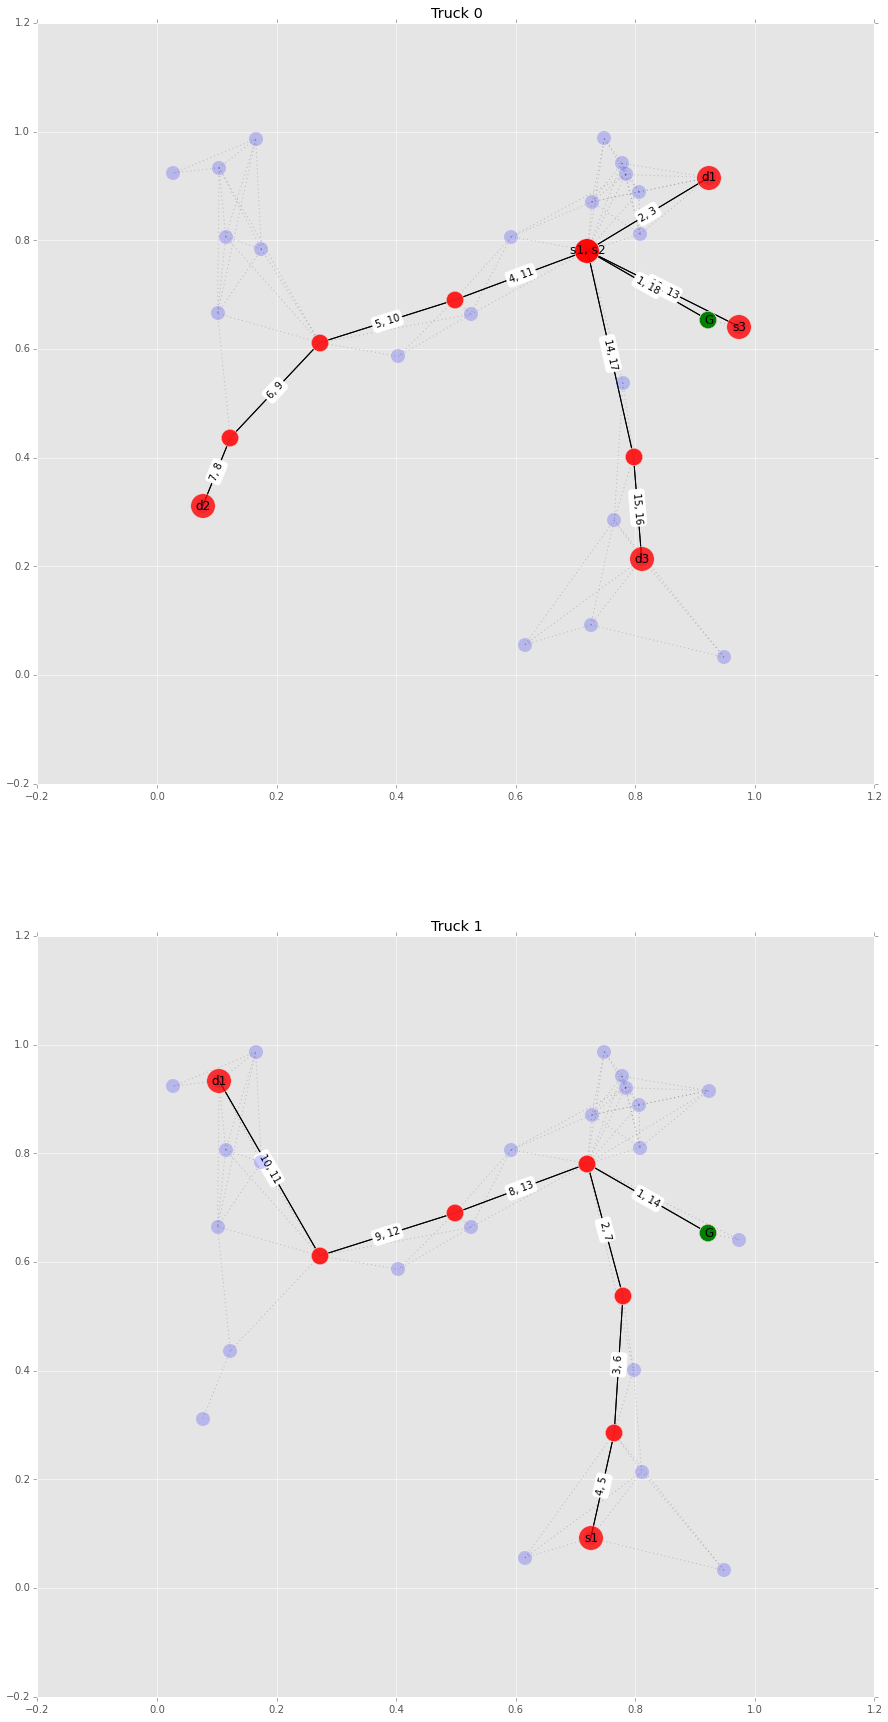

In [26]:
plt.figure(figsize=(15,(15*K)), dpi=300)

for t in xrange(len(bState)):
    plt.subplot(K, 1, t+1)
    #Edge labels
    bState[t].pathToEdges()
    eLab = {}
    i = 0
    for e in bState[t].edges:
        try:
            eLab[e] = eLab[e] + ", " + str(i+1)
            i += 1
        except KeyError:
            eLab[e] = str(i+1)
            i += 1

    #Node labels     
    nLab = {}
    nLab[garage] = "G"
    i = 0
    for p in bState[t].p:
        s,d = p.li()
        try:
            nLab[s] = nLab[s] + ", s" + str(i+1)
        except KeyError:
            nLab[s] = "s" + str(i+1)
            
        try:
            nLab[d] = nLab[d] + ", d" + str(i+1)
            i += 1
        except KeyError:
            nLab[d] = "d" + str(i+1)
            i += 1
            
    #package nodes vs intermediate nodes
    pNodes = []
    iNodes = []
    for p in bState[t].p:
        pNodes.extend([p.s,p.d])

    for n in bState[t].path:
        if not(n in pNodes):
            iNodes.append(n)

    #Draw whole graph
    nx.draw_networkx_nodes(G,posD, alpha=0.2, node_color="b", node_size=200) # Draw nodes
    nx.draw_networkx_edges(G,posD, alpha=0.2, style="dotted") # Draw edges

    #Draw nodes
    nx.draw_networkx_nodes(G,posD, nodelist=pNodes, node_size=600, alpha=.8)
    nx.draw_networkx_nodes(G,posD, nodelist=iNodes, alpha=.8, node_color=(1,0.1,0.1))
    nx.draw_networkx_edges(G,posD,edgelist=bState[t].edges)

    #Draw garage
    nx.draw_networkx_nodes(G,posD, nodelist=[garage], node_color="g")

    #Draw labels
    nx.draw_networkx_labels(G, posD, labels=nLab) # Draw node numbers
    nx.draw_networkx_edge_labels(G,posD,eLab)   # Draw edge numbers
    plt.title('Truck ' + str(t))

plt.show()